In [1]:
import numpy as np
import pandas as pd
import glob
import h5py
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
from pickle import load
import numpy as npls
import tensorflow as tf
import glob

%matplotlib inline

In [2]:
outdir = "output"
h5f = h5py.File(outdir + "/output.h5", 'r')

outdir_qp = "output_qp4"
h5f_qp = h5py.File(outdir_qp + "/output.h5", 'r')

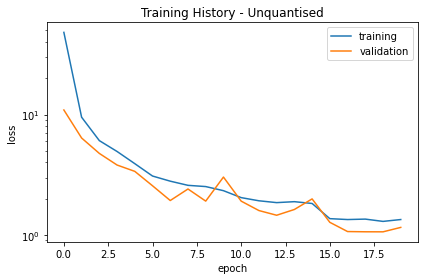

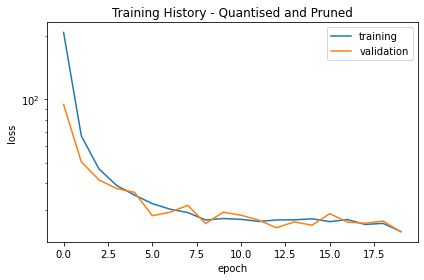

In [3]:
def make_plot_training_history(h5f, title):
    loss = h5f['loss'][:]
    val_loss = h5f['val_loss'][:]
    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Training History - %s"%title)

    plt.semilogy()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.tight_layout()

make_plot_training_history(h5f, "Unquantised")
make_plot_training_history(h5f_qp, "Quantised and Pruned")

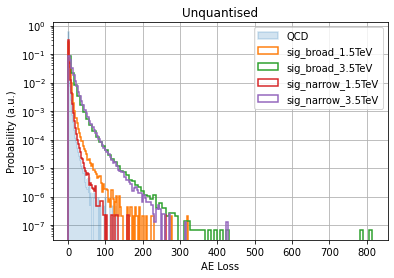

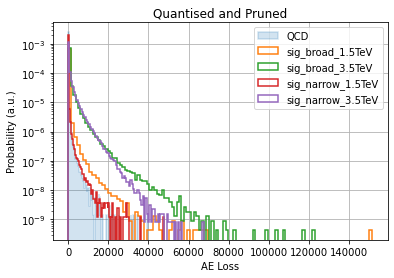

In [4]:
def mse_loss(inputs, outputs):
    return np.mean((inputs-outputs)*(inputs-outputs), axis=-1)

def ae_loss(h5f, title, anomalies_loc):
    plt.figure()

    for f in ["QCD"]+glob.glob(anomalies_loc):
        
        if f == "QCD":
            fill, alpha = [True, 0.2]
            inval = h5f[f][()]
            name = f
        else:
            fill, alpha = [False, 1]
            inval = h5py.File(f, 'r')["jetConstituentsList"][()]
            name = os.path.basename(f)[:-3]

        outval = h5f["predicted_"+name][()]

        lossQCD = mse_loss(np.reshape(inval, [-1, 16*3*1]), np.reshape(outval, [-1, 16*3*1]))
        maxScore = np.max(lossQCD)

        # plot AE Loss
        plt.hist(lossQCD, bins=100, label=name, density=True, range=(0, maxScore), 
                 histtype='step', fill=fill, alpha=alpha, linewidth=1.5)

    plt.semilogy()
    plt.title(title)
    plt.xlabel("AE Loss")
    plt.ylabel("Probability (a.u.)")
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.show()
    
ae_loss(h5f, "Unquantised", "../../data/sig*")
ae_loss(h5f_qp, "Quantised and Pruned", "../../data/sig*")

In [5]:
def metrics(h5f, anomalies_loc):
    lossQCD = mse_loss(np.reshape(h5f["QCD"][()], [-1, 16*3*1]), np.reshape(h5f["predicted_QCD"][()], [-1, 16*3*1]))
    
    metrics = []
    
    for f in glob.glob(anomalies_loc):
        name = os.path.basename(f)[:-3]
        
        anomaly = h5py.File(f, 'r')["jetConstituentsList"][()]
        loss_anomaly = mse_loss(np.reshape(anomaly, [-1, 16*3*1]), np.reshape(h5f["predicted_"+name][()], [-1, 16*3*1]))

        true_val = np.concatenate((np.ones(loss_anomaly.shape[0]), np.zeros(lossQCD.shape[0])))
        pred_val = np.concatenate((loss_anomaly, lossQCD))

        fpr, tpr, threshold = roc_curve(true_val, pred_val)
        auc_data = auc(fpr, tpr)
        
        metrics.append([name, fpr, tpr, auc_data])
    
    return np.array(metrics, dtype=object)

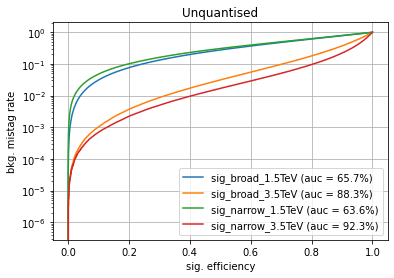

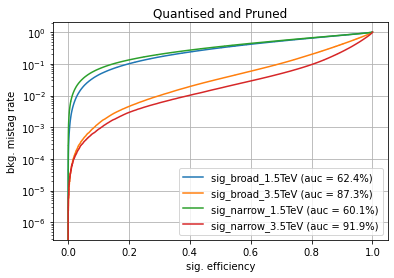

In [6]:
def plot_roc(h5f, title, anomalies_loc):
    for sig_metrics in metrics(h5f, anomalies_loc):

        plt.plot(sig_metrics[2], sig_metrics[1], label="%s (auc = %.1f%%)"%(sig_metrics[0], sig_metrics[3]*100.))

        plt.semilogy()
        plt.title(title)
        plt.xlabel("sig. efficiency")
        plt.ylabel("bkg. mistag rate")
        plt.grid(True)
        plt.legend(loc="lower right")
         
    plt.show()
    
plot_roc(h5f, "Unquantised", "../../data/sig*")
plot_roc(h5f_qp, "Quantised and Pruned", "../../data/sig*")

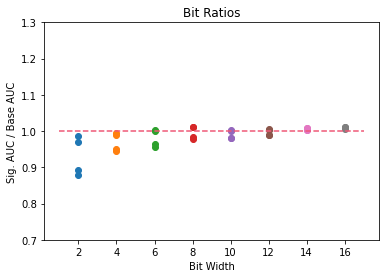

In [7]:
def ratios(anomalies_loc):
    h5f = h5py.File("output/output.h5", "r")
    base = metrics(h5f, anomalies_loc)
    plt.hlines(1, 1, 17, linestyles='--', color='#ef5675', linewidth=1.5)
    plt.ylim(0.7, 1.3)
    
    for i in range(2, 17, 2):
        h5f_qp = h5py.File("output_qp"+str(i)+"/output.h5", "r")
        bits = metrics(h5f_qp, anomalies_loc)
        plt.scatter([i]*len(base), bits[:,3]/base[:,3])
        
    # plt.legend()
    plt.xlabel("Bit Width")
    plt.ylabel("Sig. AUC / Base AUC")
    plt.title("Bit Ratios")
    plt.show()
    
ratios("../../data/sig*")